In [ ]:
!pip install svetlanna
!pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil

In [2]:
import torch
import matplotlib.pyplot as plt

from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna import wavefront as w
from svetlanna.units import ureg

# Дифракция на апертурах различной формы. Расчет на видеокарте

В этом примере приведено решение задачи дифракции плоской волны на апертурах различной формы с использованием объектов из модуля `svetlanna.elements`.
Дифракция будет вычисляться с использованием графического процессора (GPU).

При использовании Google Colab предварительно измените тип среды выполнения ("Runtime type"), чтобы использовать аппаратный ускоритель GPU, например, `T4 GPU`.

По умолчанию в этом ноутбуке используется CUDA GPU.
Вы можете раскомментировать устройство, которое хотите использовать, в ячейке ниже.

In [ ]:
device = "cuda"
# device = "mps"
# device = "cpu"

## Создание расчетной сетки и использованием класса `SimulationParameters`

In [9]:
# размер экрана, мм
lx = 8 * ureg.mm
ly = 8 * ureg.mm

# расстояние между экраном и апертурой, мм
z = 220 * ureg.mm

# длина волны, нм
wavelength = 1064 * ureg.nm

# количество расчетных точек по горизонтали и вертикали
Nx = 1024
Ny = 1024

# создание расчетной сетки
sim_params = SimulationParameters({
    'W': torch.linspace(-lx / 2, lx / 2, Nx),
    'H': torch.linspace(-ly / 2, ly / 2, Ny),
    'wavelength': wavelength,
})

# перенос sim_params на выбранное устройство
sim_params = sim_params.to(device)

In [10]:
# создание двухмерной сетки по осям W и H
x_grid, y_grid = sim_params.meshgrid(x_axis='W', y_axis='H')

## Создание плоской волны с использованием `svetlanna.wavefront.plane_wave`

Создадим плоскую волну, которая падает на поверхность апертуры:

In [12]:
# создание плоской волны
incident_field = w.Wavefront.plane_wave(
    simulation_parameters=sim_params,
    distance=0 * ureg.cm,
    wave_direction=[0, 0, 1]
)

# перенос incident_field на выбранное устройство
incident_field = incident_field.to(device)

## Создание круглой апертуры с использованием класса `svetlanna.elements.RoundAperture` 

In [13]:
radius = 1 * ureg.mm

round_aperture = elements.RoundAperture(
    simulation_parameters=sim_params,
    radius=radius,
)

# перенос round_aperture на выбранное устройство
round_aperture = round_aperture.to(device)

Посмотрим как выглядит функция пропускания апертуры с использованием метода класса `.get_transmission_function()`:

In [14]:
aperture_transmission_function = round_aperture.get_transmission_function()

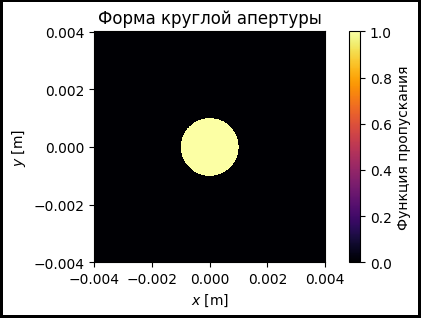

In [17]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(
    x_grid.numpy(force=True),
    y_grid.numpy(force=True),
    aperture_transmission_function.numpy(force=True),
    cmap='inferno'
)
ax.set_aspect('equal')
ax.set_title('Форма круглой апертуры')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='Функция пропускания')

## Распределение интенсивности на экране после распространения плоской волны через круглую апертуру

В этой части решена прямая задача дифракции на апертуре круглой формы с использованием метода углового спектра из класса `FreeSpace`


In [18]:
field_after_aperture = round_aperture.forward(
    incident_wavefront=incident_field
)

free_space = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=z,
    method="AS"
)
# перенос free_space на выбранное устройство
free_space = free_space.to(device)

output_wavefront = free_space.forward(
    incident_wavefront=field_after_aperture
)

output_intensity = output_wavefront.intensity

Чтобы убедиться, что `output_intensity` находится — а значит, и вычисляется — на конкретном устройстве, вы можете вывести устройство, на котором хранится `output_intensity`:

In [ ]:
print(output_intensity.device)

Визуализируем рассчитанное распределение интенсивности:

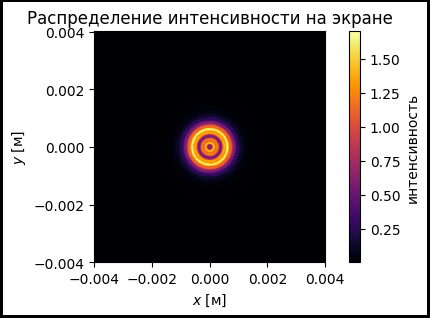

In [21]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(
    x_grid.numpy(force=True),
    y_grid.numpy(force=True),
    output_intensity.numpy(force=True),
    cmap='inferno'
)
ax.set_aspect('equal')
ax.set_title('Распределение интенсивности на экране')
ax.set_xlabel('$x$ [м]')
ax.set_ylabel('$y$ [м]')
fig.colorbar(im1, label='интенсивность')

## Создание апертуры произвольной формы

В качестве примера создадим апертуру похожую на мягкую апертуру из статьи [[1]](https://opg.optica.org/ao/abstract.cfm?uri=ao-59-18-5348)

Форма апертуры определяется выражением:

$$
r=R + S(\theta)=R(1 + \dfrac{s}{2}(1 + \sin{M\theta})),
$$

где $R$ - радиус круглой апертуры, $M$ - количество зубцов, $s$ - отношение $h$ к $r$.

Создадим апертуру заданной формы:

In [24]:
radius_soft = 1 * ureg.mm

r = torch.sqrt(x_grid**2 + y_grid**2)
M = 32

s = 0.1

theta = torch.atan2(y_grid, x_grid)
shape = r *( 1 + s / 2 *(1 + torch.sin(M*theta)))
shape = shape < 0.0015

Создадим нужную апертуру с использованием класса `Aperture` из модуля `svetlanna.elements`

In [25]:
soft_aperture = elements.Aperture(simulation_parameters=sim_params, mask=shape)
# перенос soft_aperture на выбранное устройство
soft_aperture = soft_aperture.to(device)

Посмотрим форму апертуры с использованием метода класса `.get_transmission_function()`:

In [26]:
aperture_transmission_function = soft_aperture.get_transmission_function()

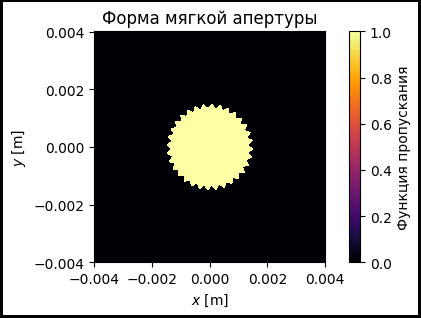

In [31]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(
    x_grid.numpy(force=True),
    y_grid.numpy(force=True),
    aperture_transmission_function.numpy(force=True),
    cmap='inferno'
)
ax.set_aspect('equal')
ax.set_title('Форма мягкой апертуры')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='Функция пропускания')

## Распределение интенсивности после прохождения мягкой апертуры

В этой части решим прямую задачу дифракции на мягкой апертуры с использованием метода углового спектра

In [32]:
field_after_aperture = soft_aperture.forward(
    incident_wavefront=incident_field
)

free_space = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=z,
    method="AS"
)

output_wavefront = free_space.forward(
    incident_wavefront=field_after_aperture
)

output_intensity = output_wavefront.intensity

Визуализируем распределение интенсивности на экране:

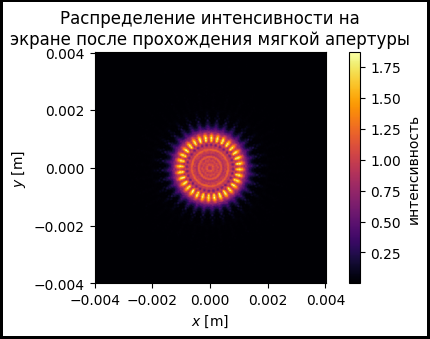

In [34]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(
    x_grid.numpy(force=True),
    y_grid.numpy(force=True),
    output_intensity.numpy(force=True),
    cmap='inferno'
)
ax.set_aspect('equal')
ax.set_title('Распределение интенсивности на\nэкране после прохождения мягкой апертуры')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='интенсивность')

Чтобы убедиться, что `output_intensity` находится — а значит, и вычисляется — на конкретном устройстве, вы можете вывести устройство, на котором хранится `output_intensity`:

In [ ]:
print(output_intensity.device)